# Face Recognition Exploration

In this exploration, I dive deep into facial verification using the [Labelled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/) dataset.

In [1]:
from __future__ import print_function

import glob
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, LocallyConnected2D, Dropout, Lambda, SpatialDropout2D
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, MaxPooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

import numpy as np

In [2]:
To achieve optimal performance during my experiments, I ensured that GPU acceleration was enabled. It's always a good practice when working with deep learning models.

'/device:GPU:0'

#1. Load Dataset

As detailed above, I will be using the well know Labelled faces in the wild dataset for face verification. [LFW dataset](https://www.tensorflow.org/datasets/catalog/lfw). 


Having a GPU enabled was crucial for this exploration. Deep learning models, especially those dealing with images, can be computationally intensive. Utilizing GPU acceleration, I was able to significantly speed up the training process.

In [3]:
!apt-get install wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [4]:
# "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
!wget "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"

--2022-12-04 11:45:23--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz.1’

lfw-deepfunneled.tg 100%[===================>] 103.72M  12.6MB/s    in 9.8s    

2022-12-04 11:45:34 (10.5 MB/s) - ‘lfw-deepfunneled.tgz.1’ saved [108761145/108761145]



In [5]:
!tar -xvf "lfw-deepfunneled.tgz"

Streaming output truncated to the last 5000 lines.
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0012.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0013.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0014.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0015.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0016.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg
lfw-deepfunne

In [6]:
# Find list of people from file structure
id_list = os.listdir('lfw-deepfunneled')
# Create a dictionary between identity and images of person
id_img_dict = {}
for id in id_list:
   imgs = glob.glob('lfw-deepfunneled/'+id+'/*.jpg')
   id_img_dict[id] = imgs


In [7]:
# Load .txt files of restricted set pairs and unrestricted set people
!wget "http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"
!wget "http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"
!wget "http://vis-www.cs.umass.edu/lfw/peopleDevTrain.txt"
!wget "http://vis-www.cs.umass.edu/lfw/peopleDevTest.txt"

--2022-12-04 11:45:39--  http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56579 (55K) [text/plain]
Saving to: ‘pairsDevTrain.txt.1’

pairsDevTrain.txt.1 100%[===================>]  55.25K   121KB/s    in 0.5s    

2022-12-04 11:45:40 (121 KB/s) - ‘pairsDevTrain.txt.1’ saved [56579/56579]

--2022-12-04 11:45:41--  http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26002 (25K) [text/plain]
Saving to: ‘pairsDevTest.txt.1’

pairsDevTest.txt.1  100%[===================>]  25.39K   109KB/s    in 0.2s    

2022-12-04 11:45:41 (109 KB/s) - ‘pairsDevTest.txt.1’ saved 

In [8]:

#  import as numpy array and operate on lengths differently
pairsDevTrain_file = open('pairsDevTrain.txt')
# Skip first line
next(pairsDevTrain_file)
train_pairs = [np.array( line.split()) for line in pairsDevTrain_file]

#  import as numpy array and operate on lengths differently
pairsDevTest_file = open('pairsDevTest.txt')
# Skip first line
next(pairsDevTest_file)
test_pairs = [np.array( line.split()) for line in pairsDevTest_file]
val_pairs = random.sample(test_pairs,256)

#  import as numpy array and operate on lengths differently
peopleDevTrain_file = open('peopleDevTrain.txt')
# Skip first line
next(peopleDevTrain_file)
train_people = [np.array( line.split()) for line in peopleDevTrain_file]

#  import as numpy array and operate on lengths differently
peopleDevTest_file = open('peopleDevTest.txt')
# Skip first line
next(peopleDevTest_file)
test_people = [np.array( line.split()) for line in peopleDevTest_file]
val_people = random.sample(test_people,256)

# 2A. Prepare Data

As I will use the LFW Unrestricted Training protcol we need to form training pairs from the data contained in the [people file](http://vis-www.cs.umass.edu/lfw/peopleDevTrain.txt) that we have downloaded into the array `train_people`. 
The function `gen_unrestricted_pairs` in the code cell below iterates through the `train_people` array. For each ith individual with greater then 1 available image, it will create matching pairs using a maximum $n$ images. This will create $n_{pair} = \lfloor{(n^2-n)/2}\rfloor$. An equal number of unmatched pairs are then created using images from the ith idividual and a single image from $n_{pair}$ other indivduals. This results in a balanced dataset with the same number of matching and non-matching pairs. 

In [9]:
p_max = 8 # Maximum number of images to used to form pairs for any given identity


# Function to create list of unrestricted pairs 
unrestricted_pairs = []
def gen_unrestricted_pairs(people_array):
   n_people = int(np.shape(people_array)[0])
   # Subfunction that creates all image pairs
   def image_pairs_ind(id,tot_img):
      '''
      input: tot_img   #Total number of images to be included
             id        # String for name of person   
      ouput: pairs_ind #Output format ID, ID, img1, img2 (where images start at 1) same form as pairsDevTrain files
      '''
      k=0
      if tot_img ==2:
         pairs_ind = [id,1,id,2,'0']
      else:
        for i in range(tot_img): 
          for j in np.arange(i+1,tot_img):
            if k==0:
              pairs_ind = [id,i+1,id,j+1,'0']
            else:  
              next_ind = np.array([id,i+1,id,j+1,'0'])
              pairs_ind = np.vstack((pairs_ind,next_ind))  
            k=+1 
      return pairs_ind                   
   
   # Sub function that creates and array of negative matching id's and index images
   # Can generate at least any equal no of negative pairs to positive
   # If no positive pairs exist then return one negative pair   
   def neg_pair_id_ind(id,id_no,n_max):
      '''
      input: 
             id        # String for name of person   
             id_no     # line number for id from person_array
             n_max     # needs to be same as number of generated pairs
      ouput: pairs_ind #Output format ID, ID, img1, img2 (where images start at 1)
      ''' 
      sel_lines = np.append(np.arange(0,id_no),np.arange(id_no+1,n_people)) #  Range of ids excluding current id
      neg_id_lines = np.random.choice(sel_lines, n_max, replace=True)      #  Choose img_tot ids from range of ids 
      # Iterate through id's select one image at random where multiple are available and append to array
      k=0
      for neg_id_line in neg_id_lines:
            neg_id=people_array[neg_id_line][0]                       # Identity
            neg_imgs = int(people_array[neg_id_line][1] )               # Number of Images
            sel_img =  np.random.choice(neg_imgs) if neg_imgs >1 else 1
            if k ==0:
              pairs_ind = [id,k+1,neg_id,neg_imgs,'1'] # use k for positive image index, will increment as go through negative ids  
            else:
              pairs_ind = np.vstack((pairs_ind,[id,k+1,neg_id,neg_imgs,'1']))
            k=+1  
      return pairs_ind 


   m =0
   for line in people_array[0:n_people-2]:       # Iterate each line
   #for line in people_array[0:10]:
      id=line[0]                                # Identity
      tot_img = int(line[1])                        # Number of Images
      n_max = min(p_max,tot_img)                # Limits number of pos/neg pairs for given identity (could be random)
      num_uniq_pair = int(np.floor((n_max**2-n_max)/2)) # Maximum number of unique pairs in an array
      
      if n_max>1:      # Working with images that can produce postive pair only
        next_pos_ind = image_pairs_ind(id,n_max)     # Sub function that returns possible positive permutations for identity
        next_neg_ind = neg_pair_id_ind(id,m,num_uniq_pair)  # Subfunction that returns other identities.
        if m ==0:
          unrestricted_pairs = next_pos_ind
          unrestricted_pairs=np.vstack((unrestricted_pairs,next_neg_ind))
        else:
          unrestricted_pairs=np.vstack((unrestricted_pairs,next_pos_ind))
          unrestricted_pairs=np.vstack((unrestricted_pairs,next_neg_ind))
        m=+1  
   return unrestricted_pairs

In [10]:
# Convert Train, test and val data using this function.
ur_train_pairs = gen_unrestricted_pairs(train_people)
ur_val_pairs = gen_unrestricted_pairs(val_people)
ur_test_pairs = gen_unrestricted_pairs(test_people)
# Calculate number of available batches for trainguing
n_batch = np.floor(np.shape(ur_train_pairs)[0]/32)

seed = 2545
print(np.shape(ur_train_pairs))
rng = np.random.default_rng(seed) 
np.random.shuffle(ur_train_pairs)
np.random.shuffle(ur_val_pairs)
np.random.shuffle(ur_test_pairs)
print(ur_train_pairs[:,1:20])

(16338, 5)
[['2' 'Hugh_Grant' '7' '0']
 ['2' 'Tom_Ridge' '8' '0']
 ['1' 'Gloria_Allred' '2' '0']
 ...
 ['1' 'Mike_Miller' '2' '0']
 ['2' 'Paul_Kelleher' '1' '1']
 ['2' 'John_Velazquez' '1' '1']]


# 2B. Setup Generator/Tensorflow Dataset
In the previous step we have created an array of matching and non-matching pairs (in alphabetical order). In this next step we construct a python generator (using `create_generator` function). This generator yields images paths and match/non-match labels. The generator must be a callable and have no arguments. As detailed [here](https://tensorexamples.com/2020/07/27/Using-the-tf.data.Dataset.html), the file is passed into the function name space by nesting the generator within a callable function.


*   See "[How to quickly build a Tensorflow Trainig Pipeline](https://www.hosstechnology.com/post/how-to-quickly-build-a-tensorflow-training-pipeline)" for further details.

Note that the input pairs_array is randomly permuted by the generator. Therefore on each Epoch the order of the face pairs will be different, this will help generalise training. 

In [11]:
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =120       # Image Height (fixed)
W_trg =120       # image Width (fixed)



In [12]:
# Create a generator to yield training images/label for training pairs
# Setup to select at random (won't have epochs)


def create_generator(pairs_array):
  # Randomly permute array 
  #pairs_array= np.random.permutation(pairs_array)
  # Convert arrays to iterators to include in generator
  #array_iter= iter(pairs_array)

  def gen_rnd_pairs():
    no_lines = np.shape(pairs_array)[0]
    k=0
    while True: 
       # Select a pair of unique identities at random  
       #line_no = np.random.choice(no_lines)
       #line = pairs_array[line_no]
       # Select lines seqentially
       line = pairs_array[k]

       id1=line[0]
       id2=line[2]  
       img_no1 = line[1]
       img_no2 = line[3]
       img_path1=id_img_dict[id1][int(img_no1)-1] 
       img_path2=id_img_dict[id2][int(img_no2)-1]
       y_label = line[4]  
       
       # Allocate images to IDs 
       yield [img_path1,img_path2],y_label
       if k > batch_size*int(n_batch):
         k=0
         np.random.shuffle(pairs_array)
       else:  
         k+=1

  return gen_rnd_pairs


Given the generator function, we can turn this into a tensorflow dataset uisng the [tf.data.Dataset.from_generator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method. Within the function `gen_tr_datasets` that sets up the dataset, we also map the function `data_pipe` to the dataset. This sub-function reads images from the paths output by the generator.


In [13]:
# Subfunction to read images from file path, resize, scale and offset.
def data_pipe(img_paths,label):
  img1_file = tf.io.read_file(img_paths[0])
  img2_file = tf.io.read_file(img_paths[1])
  img1 = tf.image.decode_image(img1_file)
  img2 = tf.image.decode_image(img2_file)
  img1 = tf.image.convert_image_dtype(img1, tf.float32) # Cast and normalize the image to [0,1]
  img2 = tf.image.convert_image_dtype(img2, tf.float32) # Cast and normalize the image to [0,1]
  img1 = tf.image.resize_with_pad(img1, H_trg,W_trg) # Resize all image
  img2 = tf.image.resize_with_pad(img2, H_trg,W_trg) # Resize all images
  # Scale image as required.
  img1 = img1-0.5
  img2 = img2-0.5
  return [img1,img2],label

# Convert generator into tensorflow dataset
def gen_tr_datasets(pairs_array):    
    # Define Datasets 
    gen_rnd_pairs = create_generator(pairs_array)
    tr_dataset = tf.data.Dataset.from_generator(gen_rnd_pairs, output_signature=(
         tf.TensorSpec(shape=(2,), dtype=tf.string),tf.TensorSpec(shape=(), dtype=tf.int8)))
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size) 
    return tr_dataset



Convert the python arrays into datasets.

In [14]:

train_dataset = gen_tr_datasets(ur_train_pairs)
test_dataset = gen_tr_datasets(ur_test_pairs)
val_dataset = gen_tr_datasets(ur_val_pairs)


Plot some examples of the training dataset.

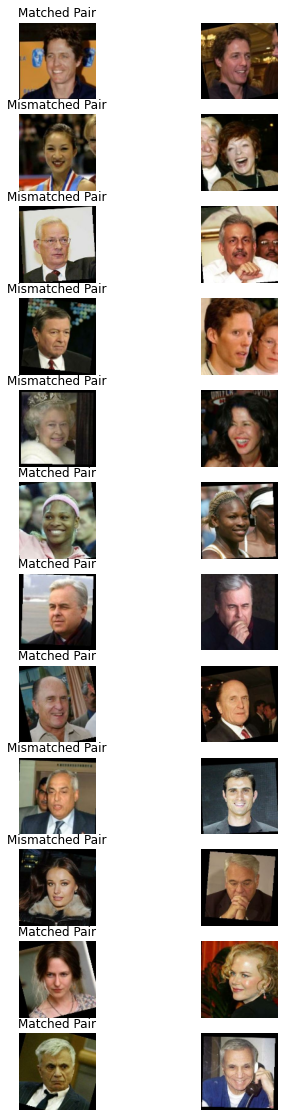

In [15]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(n_plots,2,figsize=(6,20))
label_str = ('Matched Pair','Mismatched Pair')
for imgs,label in train_dataset.take(n_plots):  # Only take a single example
  img1=np.squeeze(imgs[:,0,:,:,:])
  img2=np.squeeze(imgs[:,1,:,:,:])
  axarr[i,0].imshow(img1[0,:,:,:]+0.5)
  axarr[i,0].axis('off')
  axarr[i,0].set_title(label_str[int(label[0])])
  axarr[i,1].imshow(img2[0,:,:,:]+0.5)
  axarr[i,1].axis('off')
  i = i+1
plt.show()






 


# 3A. Build CNN Forming Branches of Siamese network
In this section I will construct a convolution network `conv_network` that can be used as the branches of the siamese network. An example of a suitable siamese network architecture is seen in "Small Sample Face Recognition Algorithm based on Novel Siamese Network". The first archiecture in the paper "SiameseFace1", is similar to the VGG network used for image classification and is straightfoward to implement a similar network to this. You can however explore with my own architectures for this exercise.
* A repeating unit `repeat_unit` is given in the code cell below and containing many of the layers described below allows convolution type networks to be easilty constructed.


 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 
 * Locally connected convolution layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LocallyConnected2D) Local connnection is used in some early networks for facial recognition. It is possible to implement these in Tensorflow keras, however they are very memory intensive and slow to run.
 * Batch Normalization layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) 
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) 
 

In [16]:
# Example of a Basic Repeating unit

def repeat_unit(inputs, num_channels=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=False):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution, nominally ReLU. 
    x = output of repeat_unit
    """
    conv = Conv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                  kernel_initializer='he_normal')
    x = conv(inputs)
    
    if activation is not None:
        x = Activation(activation)(x)

    if batch_normalization:
        x = BatchNormalization()(x)

    return x


In [17]:
def conv_network(input_shape):
    """
    Inputs:
       input Shape: (Define H,W, no. channels) of network input
                    used in Model Input definition below
    Output 
       model:       keras Model returned by this function.                          
    """
    
    
    # Define input of model
    inputs = Input(shape=input_shape)

    ### Your Network Here #####
    x = repeat_unit(inputs=inputs, num_channels=32, batch_normalization=False)
    x = repeat_unit(inputs=x, num_channels=64, batch_normalization=False)
    x = repeat_unit(inputs=x, num_channels=64, batch_normalization=False)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
   # x = SpatialDropout2D(0.2)(x)

    x = repeat_unit(inputs=x, num_channels=128, batch_normalization=False)
    x = repeat_unit(inputs=x, num_channels=128, batch_normalization=False)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
   # x = SpatialDropout2D(0.2)(x)

    x = repeat_unit(inputs=x, num_channels=256, batch_normalization=False)
    x = repeat_unit(inputs=x, num_channels=256, batch_normalization=False)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    x = repeat_unit(inputs=x, num_channels=512, batch_normalization=False)
    x = repeat_unit(inputs=x, num_channels=512, batch_normalization=False)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    #x = SpatialDropout2D(0.2)(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu',kernel_initializer='he_normal')(x)
    #x = Dropout(0.4)(x)
    x = Dense(400, activation='relu',kernel_initializer='he_normal',
              bias_regularizer = regularizers.L2(1e-2),
              kernel_regularizer=regularizers.L2(1e-2))(x)
    x = Dense(400, activation='relu',kernel_initializer='he_normal')(x)
    
    # Model definition
    model = Model(inputs=inputs, outputs=x)
        
    return model

In [18]:
input_shape =(120, 120, 3)
conv_model= conv_network(input_shape=input_shape)
conv_model.compile()
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 activation (Activation)     (None, 120, 120, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 120, 120, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 64)      36928     
                                                                 
 activation_2 (Activation)   (None, 120, 120, 64)      0     

## 3B: Siamese Top Level

In the code cell below you can complete the top level of the Siamese Network. The top level will need to contain 2 instances of the CNN model. The Kearas [functional API](https://keras.io/guides/functional_api/) usefully allows models to be called like layers and therefore allows the same instance of the base CNN of the siamese network to be called twice. Both instances will share the same weights.

It is also recommended to implement the distance function $D_w(\overrightarrow{X_1},\overrightarrow{X_2})$ detailed in the [Hadsell](https://ieeexplore.ieee.org/document/1640964) paper as separate model within the Siamese network. The distance calculated can then be passed to the custom loss function as descibed in the next step. The functional API allow the distance network to have two inputs one from each of the CNN branches.

* Models with multiple Inputs and Outputs is discussed [here](https://keras.io/guides/functional_api/) (see 1/2 way down page)

In [19]:
def distance_network(vectors):

  x,y = vectors
  squared_sum = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  distance_model = tf.math.sqrt(tf.math.maximum(squared_sum, tf.keras.backend.epsilon()))

  return distance_model

In [20]:


# Top level, ensure weight sharing by processing two inputs in paralle with same network. 
def siamese_network(input_shape):
    """
    Inputs:
       input Shape: (Define H,W, no. channels) of network input
                    used in Siamese Model Input definition below
    Output 
       model:       keras Model returned by this function.                          
    """ 
    inputs = Input(shape=input_shape)
    input_shape_conv = (120,120,3)
        
    x1_input = inputs[:,0]    
    x2_input = inputs[:,1]
            
    branch_network = conv_network(input_shape_conv)
    
    x1_output = branch_network(x1_input)
    x2_output = branch_network(x2_input)
    
    distance_output = Lambda(distance_network)([x1_output, x2_output])
    
   
    siamese_model = Model(inputs=inputs, outputs=distance_output)
    
    return siamese_model


## 3C: Loss Function
I can use the "contrastive loss" shown in paper by [Hadsell 2006](https://ieeexplore.ieee.org/document/1640964). The loss function can be implemented in the custom loss function `contrastive_loss`. As this function has the form $f(y_{true},y_{pred})$ it can be complied and used in the Keras .fit training method. 

In [21]:
def contrastive_loss(y_true, y_pred):
  '''
  Inputs: 
    # y_true is binary prediction (0 similar 1 disimlar)
    # y_pred is distance between siamese networks
  Outputs:
    # loss  calculated loss
  '''    

  # (1 - Y)1/2(Dw)^2 + (Y)1/2{max(0, m-Dw)}^2
  # Y=0 for similar and Y=1 for dissimilar

  # set margin....not sure what to set this to yet, just setting to 0.1
  m = 2 #0.2

  y_true=tf.dtypes.cast(y_true, tf.float32)

  square_pred = tf.math.square(y_pred)
  margin_square = tf.math.square(tf.math.maximum(m - (y_pred), 0))
  loss = tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

  return loss

In [22]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. I can include our custom contrastive loss function, and choose Adam as the optimiser. 




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 120, 120  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 120, 120, 3)  0          ['input_2[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 120, 120, 3)  0          ['input_2[0][0]']                
 icingOpLambda)                                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


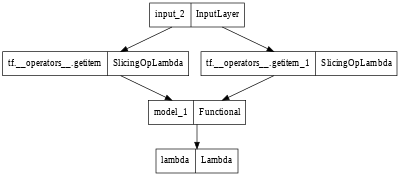

In [23]:
input_shape2 = (2,120,120,3)
model = siamese_network(input_shape2)
model.compile(loss=contrastive_loss, optimizer=Adam(lr=0.0005))
model.summary()

# Uncomment the following line to plot the model visually - warning, even for this simplified ResNet, it is quite large!
keras.utils.plot_model(model, dpi=48)


!!!Check model consumes data

In [24]:
for imgs,label in train_dataset.take(1):  # Only take a single example
  y=model(imgs,training=False)
  print(np.shape(imgs))
  print(np.shape(y))
  print(y)

(32, 2, 120, 120, 3)
(32, 1)
tf.Tensor(
[[1.7613729]
 [3.6557875]
 [3.8469439]
 [3.361208 ]
 [2.825425 ]
 [3.4292896]
 [3.2789624]
 [4.9707594]
 [2.822486 ]
 [3.3358178]
 [2.5595872]
 [2.6963232]
 [3.257543 ]
 [2.363847 ]
 [2.6819353]
 [3.932983 ]
 [4.329734 ]
 [2.0019739]
 [2.4301848]
 [3.2582436]
 [3.655953 ]
 [2.669806 ]
 [2.3534875]
 [4.319594 ]
 [3.338709 ]
 [3.1307158]
 [3.2575696]
 [2.852056 ]
 [1.935424 ]
 [2.2301004]
 [2.6926827]
 [3.3879018]], shape=(32, 1), dtype=float32)


# 5. Model Training

I will now train the complied model on the LFW dataset using the tensorflow keras `model.fit` method. 



In [25]:
epochs = 25
history = model.fit(train_dataset,epochs=epochs,steps_per_epoch=int(n_batch),validation_data=val_dataset,validation_steps=2)
#history = model.fit(train_dataset,epochs=epochs,steps_per_epoch=32,validation_data=val_dataset,validation_steps=2)

Epoch 1/25
510/510 [==============================] - 127s 243ms/step - loss: 2.4885 - val_loss: 0.8418
Epoch 2/25
510/510 [==============================] - 123s 241ms/step - loss: 0.7162 - val_loss: 0.7562
Epoch 3/25
510/510 [==============================] - 123s 241ms/step - loss: 0.5457 - val_loss: 0.7037
Epoch 4/25
510/510 [==============================] - 122s 240ms/step - loss: 0.4283 - val_loss: 0.6771
Epoch 5/25
510/510 [==============================] - 122s 240ms/step - loss: 0.3410 - val_loss: 0.6451
Epoch 6/25
510/510 [==============================] - 122s 240ms/step - loss: 0.2774 - val_loss: 0.6208
Epoch 7/25
510/510 [==============================] - 122s 239ms/step - loss: 0.2238 - val_loss: 0.7265
Epoch 8/25
510/510 [==============================] - 122s 239ms/step - loss: 0.1818 - val_loss: 0.7921
Epoch 9/25
510/510 [==============================] - 122s 239ms/step - loss: 0.1489 - val_loss: 0.9243
Epoch 10/25
510/510 [==============================] - 122s 239m

I will plot the loss and accuracy for the training and validation data sets.

dict_keys(['loss', 'val_loss'])


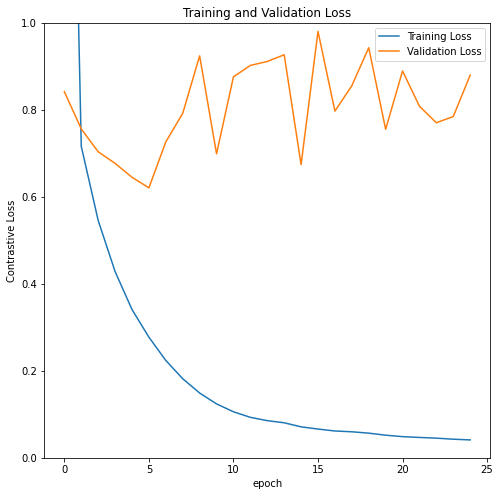

In [26]:
print(history.history.keys())


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Contrastive Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# 6. Model Testing
The model will output a distance, we must set a threshold value that determines if the predicted label should be 0 for a match or 1 for non-match. You can inspect the output of my model to determine the optimal threshold. In the code cells we create a classification report, a confusion matrix and also plot a few examples from the test set.

1.4375695


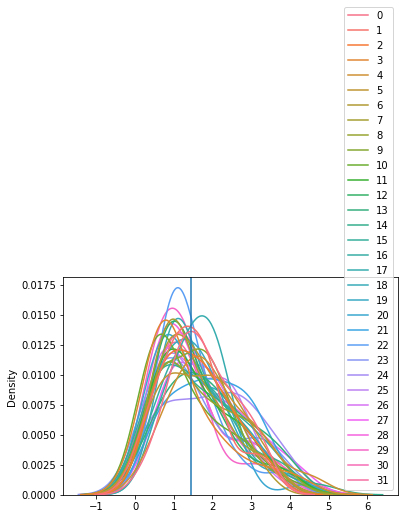

In [27]:
import seaborn as sns
n_test = 32 # number of batches to use

distance_container =[]
for image_batch,label_batch in test_dataset.take(n_test): # test_dataset.take(n_test):
    distance = model(image_batch,training=False)
    dist=((distance.numpy()).flatten())
    distance_container.append(dist)

import seaborn as sns
test=list(distance_container)
medians= np.median(distance_container)
print(medians)
sns.kdeplot(data=test)
plt.axvline(medians)

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [28]:
n_test = 32 # number of batches to use
threshold = medians
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    distance = model(image_batch,training=False)
    # Threshold distance and convert to prediction
    predictions = distance>threshold
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = 1.0*(np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size))))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))


Create and plot a confusion matrix.

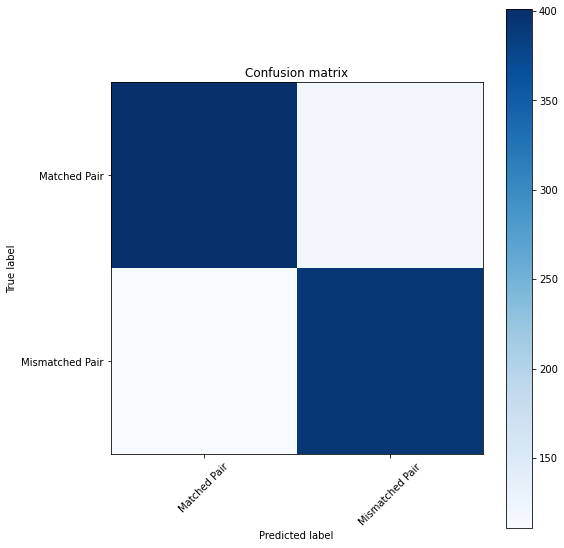

In [29]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
label_str = ('Matched Pair', 'Mismatched Pair')
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm)

Generate & print the classification report

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

                 precision    recall  f1-score   support

   Matched Pair       0.78      0.77      0.78       520
Mismatched Pair       0.77      0.78      0.77       504

       accuracy                           0.78      1024
      macro avg       0.78      0.78      0.78      1024
   weighted avg       0.78      0.78      0.78      1024



Plot some test images and predicted labels.

tf.Tensor(
[[1.2521456 ]
 [2.5491583 ]
 [2.282445  ]
 [1.685292  ]
 [1.9843192 ]
 [1.8991419 ]
 [1.0810463 ]
 [0.9167136 ]
 [1.6247517 ]
 [1.0764619 ]
 [2.5676763 ]
 [0.30893916]
 [1.0988914 ]
 [3.3874125 ]
 [3.2120113 ]
 [0.8404593 ]
 [1.4465148 ]
 [1.7109888 ]
 [0.37537962]
 [2.9384837 ]
 [1.7725394 ]
 [2.526361  ]
 [1.1541083 ]
 [1.3758287 ]
 [2.1741946 ]
 [2.458264  ]
 [1.7112539 ]
 [1.3011714 ]
 [3.192373  ]
 [2.9091258 ]
 [0.95069134]
 [1.6546807 ]], shape=(32, 1), dtype=float32)
Predictions:
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 1.]


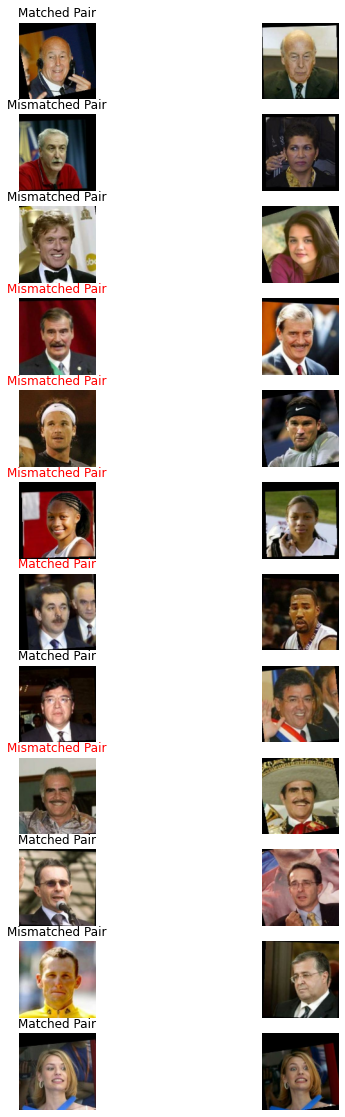

In [31]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
#distances = model.predict_on_batch(image_batch)
distance=model(image_batch,training=False)
print(distance)

# Apply a threshold as model returns distances
predictions = 1.0*np.squeeze(distance>threshold)
print('Predictions:\n', predictions)


i=0
n_plots = 12 # number of plots

f, axarr = plt.subplots(n_plots,2,figsize=(8,20))

for image_pair in image_batch[0:n_plots,:,:,:,:]:  
  img1=np.squeeze(image_pair[0,:,:,:])
  img2=np.squeeze(image_pair[1,:,:,:])
  axarr[i,0].imshow(img1[:,:,:]+0.5)
  axarr[i,0].axis('off')
  axarr[i,1].imshow(img2[:,:,:]+0.5)
  axarr[i,1].axis('off')

  color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
  axarr[i,0].set_title(label_str[int(predictions[i])],color=color)
  i = i+1
plt.show()  